In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Lab 8: Word Embeddings

### The problem: representing words as numbers

How can we represent letters, words, or sentences as numerical patterns?

This is a fundamental question for any kind of modeling work. We want our models to be about things in the world, but our models require us to represent those things as numbers.

At this point in the semester, we've seen many examples of one kind of strategy that you could use: one-hot encoding. We could imagine compiling a list of all the words in a language and assigning each one it's own number. `the` is 1, `and` is 2, and `pareidolia` is 412,359.

The trouble with this approach is that it treats each word as unique, and equally distinct from all other words. Every word is its own category of *thing*. But real language is not like this. `cognition`, `thought`, and `mind` are closely related to each other, but much more distinct from `screw`, `nail`, and `hammer`. How can we represent this numerically?

Making this even trickier is that many words can mean different things in different contexts. `screw` is a noun or a verb, and there are at least two different meanings of the verb.

So we need a way to represent words as numbers that can (1) capture the similarity between words and (2) capture the different possible meanings of a word.

Enter *word embeddings*.


### Word Embeddings

The basic idea behind a word embedding is that we will represent a word as a vector of numbers. If we measure the distance between the vectors for two words, words with more similar meanings should be closer together than words with dissimilar meanings. This is how we satisfy out first requirement of representing the similarity between words.

Word embeddings are called *embeddings* because we can think of each vector as picking out a point in a very big space of possible semantic meanings. In other words, we embed a word inside this semantic space.

What's especially amazing about these embedding spaces is that they capture many different kinds of semantic relationships. The vectors often have hundreds or thousands of dimensions, which allows the vector to represent many different aspects of the word in one pattern of numbers.

### How do we generate the embeddings?

We can learn an embedding space from natural language data.

One of the most successful approaches for learning word embeddings is to start with a very large sample of data and figure out which words occur in the same context as other words. There are different specific algorithms that get used for this, but they share the general principle that words that appear in the same contexts should have similar meanings.

For example, if we looked at words that appeared near the word `lion` in a large corpus of English text, `zoo` might be one of the words that appears relatively frequently. If we did the same for `elephant`, `zoo` might also show up. This tells us that `lion` and `elephant` share something in common. Of course, there are other context words that might be different, and those will help differentiate the meaning of `lion` from `elephant`.

These *co-occurrence* algorithms for generating semantic vectors work really well. In fact, for most natural language processing machine learning applications, developers just use pre-learned embeddings. For example, you can download GloVe Embeddings (Global Vectors for word representation) at the research group's website (https://nlp.stanford.edu/projects/glove/). Then you could build a neural network model on top of these existing embeddings. This is pretty standard practice.

But we can also generate embeddings in other ways too. That's what we're going to explore in this lab.

## Embeddings, Take 1: Semantic Classification

The first approach we're going to look at is learning embeddings as part of a text classification model. We're going to build a neural network model that can classify a movie review as positive or negative. The input to the model will be one-hot representations of the words in the vocabulary, but the very first thing the model will do is convert this one-hot representation to an embedding vector. The model can learn this conversion process.

### Getting the data

We'll start by downloading the `imdb_reviews` dataset. This is one of the examples included with keras.

There are two critical parameters that we need to specify when we load the data.

`num_words` controls the number of unique words in the dataset. This sounds weird at first: don't the reviews determine how many unique words there are? Yes, they do. But we can also simply ignore words that are rare. If a word appears very rarely in the dataset, then it'll be impossible to learn a meaningful embedding for that word. We need the word to appear in many different contexts to learn an embedding.

`maxlen` controls the maximum length of a single review. This simply truncates the review after some number of words. This is important because training the model is much easier and more efficient if we can pass in many examples that are all the same length. This allows us to use batch processing. It's possible to train with inputs of different lengths, but would require a lot more code to configure.

In [ ]:
imdb_data_raw = tf.keras.datasets.imdb.load_data(
    num_words=10000,
    maxlen=250,
)

17464789/17464789 [==============================] - 0s 0us/step


In [ ]:
(x_train, y_train), (x_test, y_test) = imdb_data_raw

### Understanding the data

Take a look at `x_train` and `y_train`. You'll see that each entry in `x_train` is a list of numbers and each entry in `y_train` is 0 or 1.


In [ ]:
# check out the data here
x_train.shape

(17121,)


The numbers in `x_train` represent the different words in the vocabulary. Keras provides a dictionary to translate words to their corresponding number. The words are arranged from most-frequent to least-frequent. We can get the list of words from Keras:

In [ ]:
word_lookup = tf.keras.datasets.imdb.get_word_index()

1641221/1641221 [==============================] - 0s 0us/step


This creates a dictionary called `word_lookup`. You can get the corresponding number for a word with `word_lookup['word']`. The number tells you the rank of the word's frequency in the dataset, so words closer to 1 are the more frequent words. Try it out:

In [ ]:
# lookup some word values
word_lookup['pewter']

84265

### Decoding the data

If we want to decode the reviews, we'll need to invert this dictionary so that we can put in a number and get the corresponding word.

This code is a little fancy. It is building a list of `(key, value)` pairs, where the `key` is the index of the word and and `value` is the word. `word_lookup.items()` gets a list of `(word, index)` values, which we then swap to be `(index + 3, word)` values.

We have to add 3 to the `index` because the first few numbers are reserved for special tokens.

- `0` is the `[PAD]` token, which is what we add to the end of a sentence when the sentence is shorter than the max length.
- `1` is the `[START]` token, which is present at the start of all reviews.
- `2` is the `[OOV]` token, or out-of-vocabulary token, which is what is used for any word that is not part of the vocabulary.
- `3` is the `[NA]` token. Honestly, I don't know why this one exists. There aren't any of them in the data.

In [ ]:
inverted_word_lookup = dict(
    (index + 3, word) for (word, index) in word_lookup.items()
)

In [ ]:
inverted_word_lookup[0] = "[PAD]"
inverted_word_lookup[1] = "[START]"
inverted_word_lookup[2] = "[OOV]"
inverted_word_lookup[3] = "[NA]"

Now we can create a funtion that takes in a list of numbers and generates the decoded review. Using `" ".join()` joins together all of the items in the list with a space in between.

In [ ]:
def decode(x):
  return " ".join(inverted_word_lookup[i] for i in x)

With the `decode()` function in place, we can read the sentences in the training set. Try running `decode(x_train[n])` with various numbers substituting for `n`.

In [ ]:
# decode some reviews here
decode(x_train[8])

"[START] when i rented this movie i had very low expectations but when i saw it i realized that the movie was less a lot less than what i expected the actors were bad the doctor's wife was one of the worst the story was so stupid it could work for a disney movie except for the murders but this one is not a comedy it is a laughable masterpiece of stupidity the title is well chosen except for one thing they could add stupid movie after dead husbands i give it 0 and a half out of 5"

One problem we will encounter if we try to use this data as-is is that each review is a different length.

In principle, we can build a neural network architecture that doesn't care about the input length (e.g., a recurrent neural netwok), but this requires either training the model one sentence at a time or some custom training code.

We'll simply add a bunch of `[PAD]` words to the end of the reviews that are shorter than the max length. We can even use a trick later to make it so that the model ignores these `[PAD]` words when it is computing the word embeddings.

To add the padding, we can use `tf.keras.utils.pad_sequences()`.

In [ ]:
x_train_pad = tf.keras.utils.pad_sequences(x_train, padding="post")

Try running the `decode()` function again and observe the added padding.

In [ ]:
# decode some reviews that have padding
decode(x_train_pad[8])

"[START] when i rented this movie i had very low expectations but when i saw it i realized that the movie was less a lot less than what i expected the actors were bad the doctor's wife was one of the worst the story was so stupid it could work for a disney movie except for the murders but this one is not a comedy it is a laughable masterpiece of stupidity the title is well chosen except for one thing they could add stupid movie after dead husbands i give it 0 and a half out of 5 [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

### New Keras Layers

To build the first embedding model we are going to need two new kinds of Keras layers that we haven't seen yet.

#### tf.keras.layers.Embedding()

The Embedding layer takes a number as input and ouputs a vector as output. The input number is the index (in this case, the index of the word in the vocabulary) and the output is an embedding vector. The mapping between index and vectors is learned. The main parameter for the Embedding layer is the dimensionality of the embedding vectors. This is where we can decide if we want 300-dimensional embeddings like GloVe, or some other number.

#### tf.keras.layers.GlobalAveragePooling1D()

We've encountered the idea of pooling before, with `MaxPooling2D()` layers in our convolutional neural networks. The basic idea behind a pooling layer is that we are combining many values into fewer values.

A GlobalAveragePooling1D() layer does pretty much what it says. It takes an average across all the inputs, and the inputs are 1D.

When might this occur? Well, suppose we have a bunch of movie reviews and we want to get an embedding vector that is representative of all the words in the review. We could first get the Embeddings for all the words, and then we could pass all of these in to a GlobalAveragePooling1D layer which will find the average embedding vector of all of the individual word vectors.

#### Masking

A few steps ago we added a bunch of `[PAD]` tokens to the data in order to make all the reviews the same length. (Numerically, the `[PAD]` token is index `0`.) If we average the embedding vectors together for an entire review, then reviews with lots of `[PAD]` tokens will tend to have vectors that are similar to each other if we include the vector for the `[PAD]` token in our average. This will make the embeddings less informative.

This is a common problem, so there's a built-in solution called *masking*. We can tell Keras to mask certain connections (basically, set them to 0) in the model. In the embedding layer, we can set `mask_zero=True`, and this will create a mask for all of the 0 (`[PAD]`) tokens. The mask will get passed along to subsequent layers, which will allow us to avoid having these tokens influence the model.



### Create the model

We're ready to build a model now.

For the first model, we're going to make the input reviews and the output the classification of whether the review is a positive or negative review.

The architecture should be:
1. Input layer with shape `(None,)` to allow for reviews of any length later on.
2. Embedding layer with 16 dimensional embeddings and masking.
3. GlobalAveragePooling1D layer to take all of the word embeddings in a review and average them together into a single joint embedding.
4. A dense hidden layer with 16 units and relu activation.
5. A dense output layer with 1 unit and sigmoid activation.

The loss function is `binary_crossentropy` (not `categorical_crossentropy` because we only have one output that is either `0` or `1` here) and the optimizer can be `adam`. You can use accuracy as a metric to see how well it is classifying.

Train the model for a few epochs. It doesn't need much.

In [ ]:
# build a model
input_layer = tf.keras.layers.Input((None,), name="Input")
embedding_layer = tf.keras.layers.Embedding(len(word_lookup), 16, mask_zero=True, name="Embedding")(input_layer)
global_pooling_layer = tf.keras.layers.GlobalAveragePooling1D(name="GlobalAveragePooling")(embedding_layer)
dense_layer = tf.keras.layers.Dense(16, activation="relu", name="Dense")(global_pooling_layer)
output_layer = tf.keras.layers.Dense(1, activation="sigmoid", name="Output")(dense_layer)

model = tf.keras.Model(input_layer, output_layer)

In [ ]:
# compile a model
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics="accuracy"
)

In [ ]:
# fit a model
with tf.device('/GPU:0'):
  model.fit(x_train_pad, y_train, epochs=5)

Epoch 1/5
536/536 [==============================] - 48s 78ms/step - loss: 0.5250 - accuracy: 0.7850
Epoch 2/5
536/536 [==============================] - 13s 25ms/step - loss: 0.2555 - accuracy: 0.9036
Epoch 3/5
536/536 [==============================] - 7s 14ms/step - loss: 0.1887 - accuracy: 0.9297
Epoch 4/5
536/536 [==============================] - 6s 11ms/step - loss: 0.1496 - accuracy: 0.9475
Epoch 5/5
536/536 [==============================] - 6s 10ms/step - loss: 0.1213 - accuracy: 0.9606


### Get the word embeddings

We've got the model trained and it can do a pretty good job at sentiment classification, but what we really want is to get the embeddings for the words.

Create a sub-model that has the embedding layer as the output.

In [ ]:
# create a sub-model
submodel = tf.keras.Model(model.input, model.get_layer("Embedding").output)

Run `predict` on the sub-model and get the embeddings for all 10,000 words in the vocabulary.

Remember that the input to the model is just a sequence of integers, where each integer represents a word. So you just need to give the model the numbers 0-9999 and get the corresponding embeddings for each.

In [ ]:
submodel.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, None)]            0         
                                                                 
 Embedding (Embedding)       (None, None, 16)          1417344   
                                                                 
Total params: 1417344 (5.41 MB)
Trainable params: 1417344 (5.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# get the embeddings
def predict_all_numbers(model):
    predictions = pd.DataFrame()
    for i in range(10000):
        number = np.array([i])
        predictions = pd.concat([predictions, pd.DataFrame(model.predict(number))])
    return predictions

In [ ]:
results = submodel.predict(np.arange(10000))

313/313 [==============================] - 0s 1ms/step


In [ ]:
%%capture
submodel_predictions = predict_all_numbers(submodel)

### Visualize the embedding space

Our embedding space is 16 dimensions. To visualize it, we'll use a dimensionality reduction algorithm to create a 2D representation.

We can't use linear discriminant analysis like we did in lab 7. While that is a dimensionality reduction technique, it only applies to situations where each item belongs to a category. Here we just have a bunch of individual word vectors with no pre-determined category relationships.

We'll use t-SNE (teese-knee, rhymes with peace-knee). t-SNE is a dimensionality reduction algorithm that emphasizes preserving local similarity relationships. In other words, once we plot the 2D representation, we can be reasonably confident that words that appear near each other have similar vectors, but we won't be able to make inferences about words that don't appear close together. The local space is meaningful, but the global space is not. Or, in other *other* words, the axes of the graph don't really mean anything in t-SNE, because those are global axes. We just care about the local clusters.

To run t-SNE, we can turn to scikit-learn.

We start by creating a `TSNE()` object.

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE()

Then we use `.fit_transform()` to do two steps at once:

1. Fit the t-SNE model to our data to learn the mapping between our embedding space and the 2d representation.
2. Run the mapping on our embeddings, to get (x,y) coordinates for each vector.

In [ ]:
two_dim_embeddings = tsne.fit_transform(results)

Now we can take the t-SNE points and turn them into a data frame. We'll name the two columns `'x'` and `'y'`.

In [ ]:
tsne_plot_data = pd.DataFrame(two_dim_embeddings, columns=['x','y'])

Next we should add a column to the dataset that indicates which word each row corresponds to. To do this, we can generate the list of words from our `inverted_word_lookup` dictionary. We'll use the list comprehension syntax to get the first 10,000 words and then assign this list to the `'word'` column.

In [ ]:
tsne_plot_data['word'] = [inverted_word_lookup[i] for i in np.arange(10000)]

We can take a look at the resulting data frame:

In [ ]:
tsne_plot_data

,x,y,word
0,-0.643896,37.622658,[PAD]
1,1.114645,23.261139,[START]
2,5.129833,23.108915,[OOV]
3,-1.213242,30.046989,[NA]
4,0.793955,23.444397,the
...,...,...,...
9995,-19.309685,-14.266568,soulless
9996,-57.520039,-6.007028,unfairly
9997,-14.273141,37.333523,grail
9998,52.221134,-42.717934,retrospect


In [ ]:
tsne_plot_data_word_samples = np.random.choice(tsne_plot_data['word'], size=300, replace=False)

We can use this data frame to plot our embedding space. We'll plot a point for each word. Using `theme_void()` in our ggplot removes all axes, scales, and legends so that we just have the data in isolation. This makes sense for this kind of visualization where the scales are arbitrary.

In [ ]:
from plotnine import ggplot, geom_point, geom_text, aes, theme_void

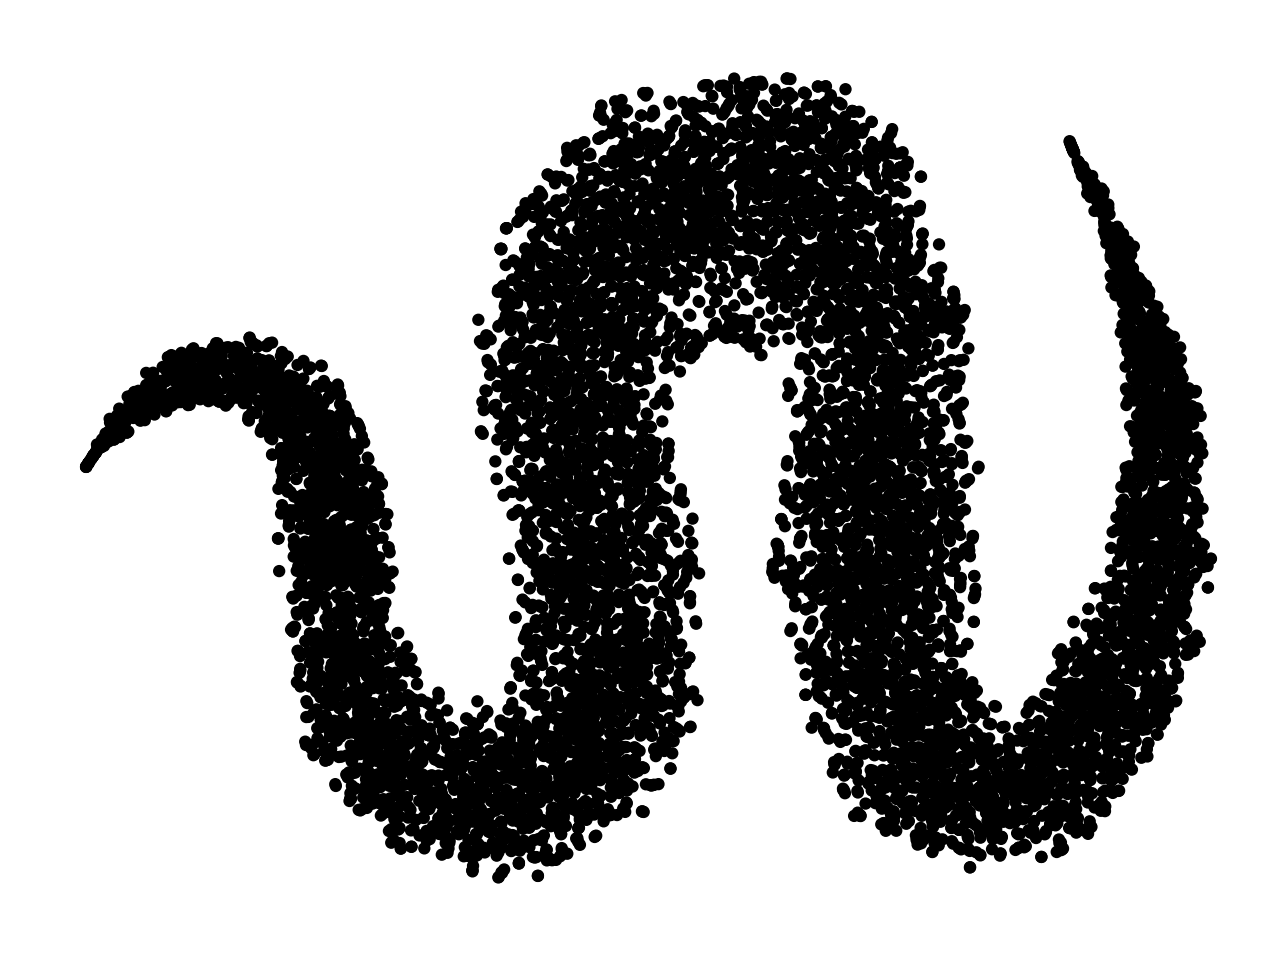

<Figure Size: (640 x 480)>

In [ ]:
(ggplot(tsne_plot_data, mapping=aes(x='x', y='y'))+
 geom_point()+
 theme_void())

What's going on? Why do we get some kind of snake-like space?

I want you to try and figure this out and come up with a way to demonstrate that you've figured it out. Brainstorm with others at your table. Ask me for help if you need ideas about how to implement your hunches.

A couple hints:

1. You can add a column to the data frame that "marks" certain words. You can then use this column to color those words a different color in the plot.
2. You can use `geom_text()` to print words directly on the plot.

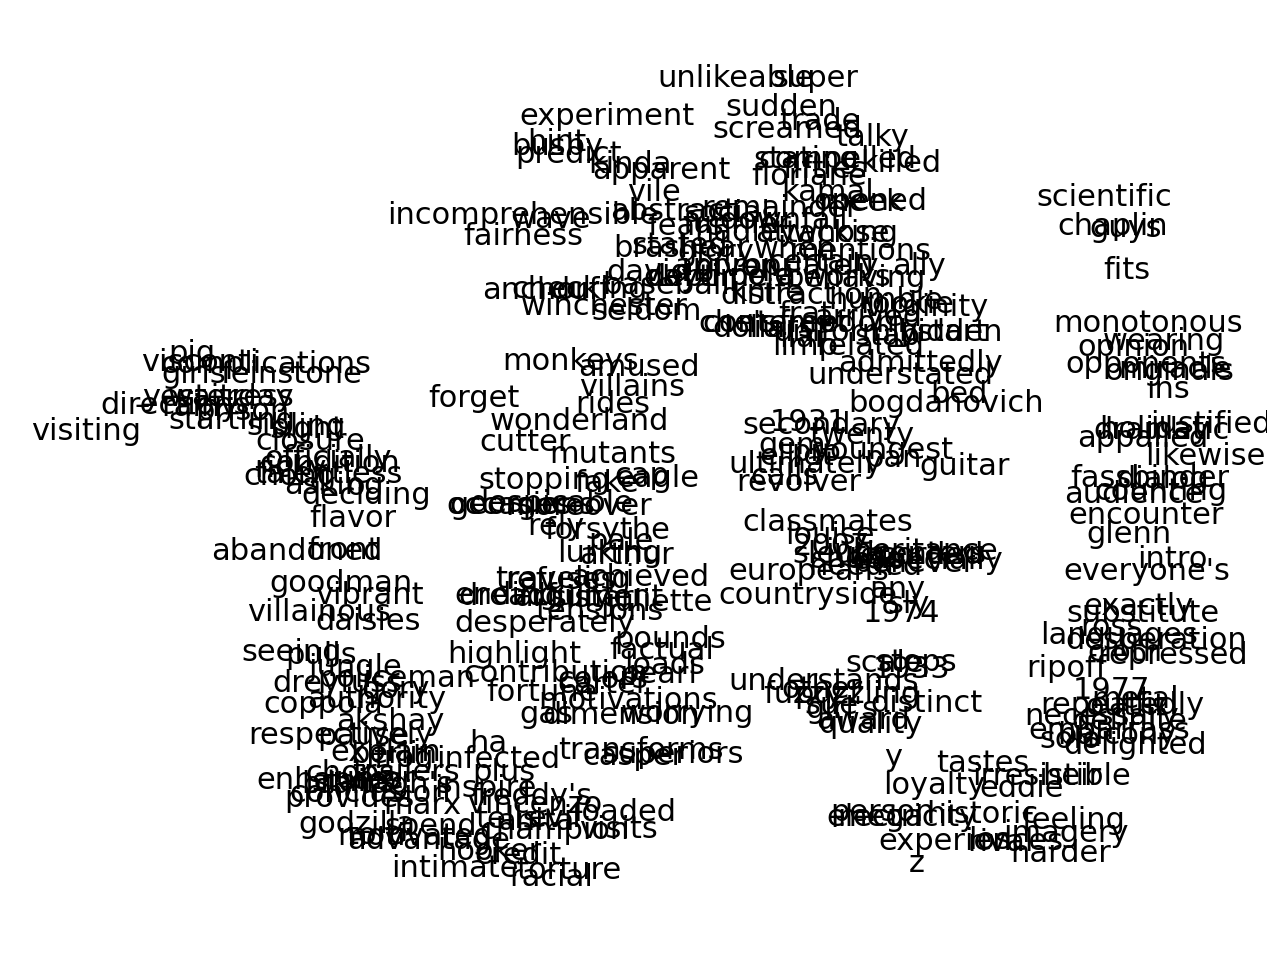

<Figure Size: (640 x 480)>

In [ ]:
# investigate! use text cells to explain what's going on as needed.

Okay!

In [ ]:
(ggplot(tsne_plot_data, mapping=aes(x='x', y='y'))+
 geom_text(data=tsne_plot_data[tsne_plot_data["word"].isin(tsne_plot_data_word_samples)], mapping=aes(label=tsne_plot_data_word_samples))+
 theme_void())

Here I'm just trying to randomly sample 300 words and see if I can find any semantic correlations between words that are nearby each other. I feel like I don't see anything here, so I'm going to try some more stuff.

In [ ]:
x_train_pad_positive = []
for i in len(x_train_pad):
  x_train_pad_positive.append(x_trai_pad[i]) if y_train[i] == 1 else None

TypeError: ignored

## Embeddings, Take 2: Next Word Prediction



The model above learned word embeddings that were specific to the task of sentiment classification. This makes sense, since the Embedding layer learns representations that will help the model reduce the loss function.

For our second model, we're going to try and learn a more generic embedding space. To do this, we'll create a model that attempts to predict a word given a short context of words. Next word prediction is the most commonly used training task for natural language models.

### Creating the dataset

We're going to create a simple version of the next word prediction task because it is much easier to program. You could probably improve the performance of this model by implenting a more nuanced version.

In our version, we're going to set a window size; let's say 5. Then we'll take a review and chop it up into groups of 5 words. We'll then split these groups of 5 up into 4 + 1. The model's job will be to predict the 5th word from the sequence of the first 4.

First, we'll define the window size. This will make it easy to change later if we want to experiment with a smaller or larger window.

In [ ]:
window_size = 5

Next, let's create the list of sentence fragments.

We can create an empty list of `fragments`. Then, use a `for` loop to loop through all of the reviews in `x_train`. Within each review, do another `for` loop that goes through the sequence `1, 6, 11, 16, ...` etc. (the `np.arange` function will be useful). Within this loop, you can `.append()` the five words onto the list of `fragments`.

For example, on the first iteration of the loop, you'll be adding `x_train[i][1:6]` to `fragments`. On the next you'll be adding `x_train[i][6:11]`. And so on.

In [ ]:
fragments = []

# write some for loops and create the fragments
for review in x_train:
    for i in np.arange(0, len(review), 5):
        fragments.append(x_train[i][i:i+5])

Now that we have these fragments, we can pull out the last word of each fragment.

In [ ]:
fragments
fragments = [lst for lst in fragments if len(lst) == window_size]

In [ ]:
final_words = [lst[-1] for lst in fragments]

We can verify this worked by looking at `fragments` and `final_word` together:

In [ ]:
fragments[1]

In [ ]:
final_words[1]

Now we can also pull the first four words out into `lead_in_words`.

In [ ]:
lead_in_words = [lst[0:window_size-1] for lst in fragments]

In [ ]:
lead_in_words[0]

Now we've got our training data. `lead_in_words` has a sequence of four words, and `final_word` has the word that the model should predict.

### Creating the model

Our model needs to take in a sequence of words and output a single word as a prediction. We'll use a recurrent model to process the sequence and output a prediction.

Create a model with:

1. An input layer with shape `(None,)` to allow for sequences of any length.
2. An embedding layer with 60-dimensional embeddings.
3. An `LSTM` layer with 150 units.
4. A `Dense` layer with 10000 outputs (one for each vocabulary item) and softmax activation.

Compile the model to use sparse_categorical_crossentropy loss, adam as the optimizer, and accuracy as a metric.

Then train the model for ~10 epochs or so. This model is slow to train, and using a GPU will make a *big* difference. Even with the GPU, this may take > 10 minutes.

In [ ]:
# create a model
input_layer = tf.keras.layers.Input((None,), name="Input")
embedding_layer = tf.keras.layers.Embedding(len(word_lookup), 60, name="Embedding")(input_layer)
lstm_layer = tf.keras.layers.LSTM(units=150, name="LSTM")(embedding_layer)
output_layer = tf.keras.layers.Dense(10000, activation="sigmoid", name="Output")(lstm_layer)

finish_sentence_model = tf.keras.Model(input_layer, output_layer, name="FinishSentenceModel")

In [ ]:
# compile a model
finish_sentence_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics="accuracy"
)

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

In [ ]:
# fit a model
with tf.device('/GPU:0'):
  finish_sentence_model.fit(lead_in_words, final_words, epochs=10)

### Get the embeddings

Create the sub-model that has the embedding layer as the output.

In [ ]:
# create a sub model
finish_sentence_submodel = tf.keras.Model(finish_sentence_model.input, finish_sentence_model.get_layer('Embedding').output)

Get the embedding vectors for all 10,000 words in the vocabulary.

In [ ]:
# get the embeddings
def finish_sentences(model):
  predictions = pd.DataFrame()
  for sentence in lead_in_words:
    predictions = pd.concat([predictions, pd.DataFrame(model.predict(sentence))])
  return predictions

In [ ]:
%%capture
with tf.device('/GPU:0'):
  finish_sentencs_submodel_predictions = predict_all_numbers(finish_sentence_submodel)

### Visualize the embedding space

Use t-SNE again to visualize the embeddings for the first 2000 items in the vocabulary. (Trying to do all 10,000 will be slow and create a very dense visualization.) You can follow the same general approach we used for model 1. The steps are:

1. Create the `TSNE()` object.
2. Run `.fit_transform()` on the embeddings.
3. Convert the output to a pandas data frame.
4. Add a word column to the data frame.
5. Use ggplot to plot the embedding space.

Hint: if you want to visualize a small subset of the words to get a sense for what the different regions of the space are, you can use `geom_text(data=plot_data.sample(50))` to override the default data object for the plot and only plot a random sample of 50 points.

In [ ]:
# generate a t-SNE visualization
two_dim_embeddings = tsne.fit_transform(submodel_predictions)

### Investigate the embeddings

While the embedding space we created here is more general than the first model we used, it is still somewhat limited because of the nature of the input.

Given that the input is all movie reviews, what kinds of clusters do you expect to see in the data?

Investigate and find out.

Hints:

1. You can add a column to the data frame (i.e., cluster) to put specific words in specific groups. Then you can add a `color` mapping to your plot to see if the hypotesized clusters show up in the space.